# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal midthickness surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob

In [2]:
micapipe_dir = '../sourcedata/Supersession_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'

subs = ['PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC018', 'PNC019', 'PNC020', 'PNC021']
ses = ''
hemis = ['L','R']
labels = ['hipp','dentate'] 

ind = [range(7262), range(7262,7262+1788)]

In [3]:
features = ['T1map','MTR','T2star','FA','ADC']
for feature in features:
    for sub in subs:
        for hemi in hemis:
            for label in labels:
                cmd = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_{feature}.shape.gii '\
                    f'-trilinear'
                if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_{feature}.shape.gii'):
                    !{cmd}


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -volume-to-surface-mapping ../sourcedata/Supersession_PNI/sub-PNC015/anat/sub-PNC015_space-nativepro_T1map.nii.gz ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC015/surf/sub-PNC015_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC015/surf/sub-PNC015_hemi-L_space-T1w_den-0p5mm_label-hipp_T1map.shape.gii -trilinear

ERROR: NAME OF FILE: sub-PNC015_space-nativepro_T1map.nii.gz
PATH TO FILE: ../sourcedata/Supersession_PNI/sub-PNC015/anat

File does not exist.


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -volume-to-surface-mapping ../sourcedata/Supersession_PNI/sub-PNC015/anat/sub-PNC015_space-nativepro_T1map.nii.gz ../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC015/surf/sub-PNC015_hemi-L_space-T1w_den-0p5mm_label-dentate_midthickness.surf.gii ../hippunfold/PNI_v1.3.0_super/hippunfold/s

In [4]:
features = ['thickness', 'gyrification', 'curvature', 'T1map','MTR','T2star','FA','ADC']
hipp_dat = np.zeros([7262+1788,2,len(subs),len(features)])*np.nan

for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                try:
                    d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/'\
                                 f'sub-{sub}_hemi-{hemi}_space-T1w'\
                                 f'_den-0p5mm_label-{label}_{feature}.shape.gii')
                    hipp_dat[ind[l],h,s,f] = d.darrays[0].data
                except:
                    print(f'sub-{sub}_{feature} not found')

In [5]:
# flip L curvatures
hipp_dat[:,0,:,2] = -hipp_dat[:,0,:,2]

/tmp/ipykernel_33186/341615489.py:1: RuntimeWarning: Mean of empty slice
  cdata = np.nanmean(hipp_dat,axis=2)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


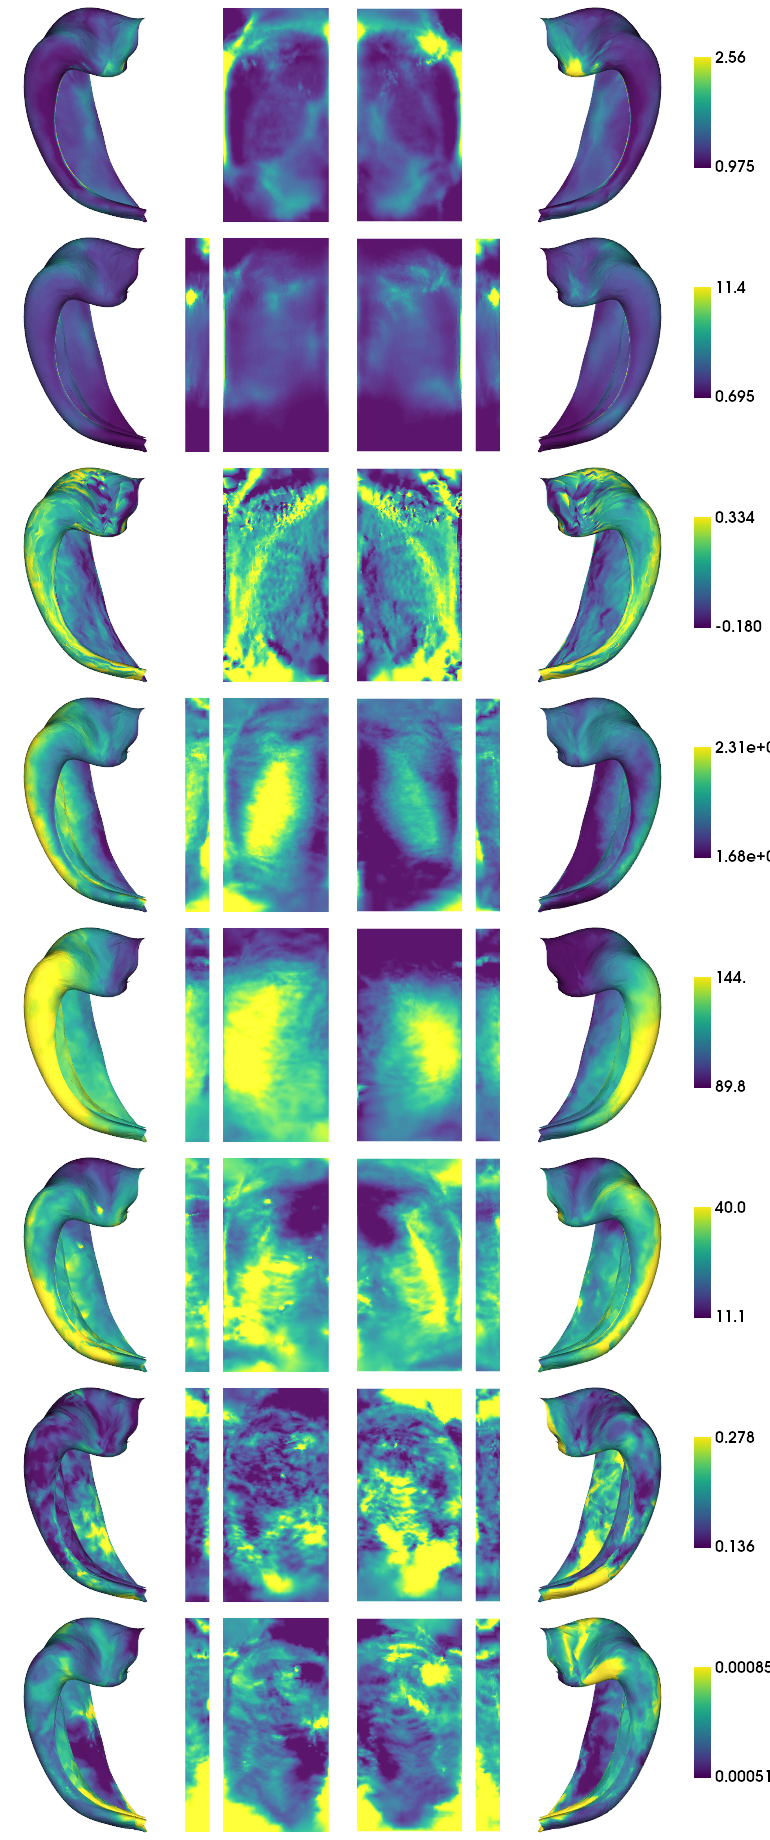

In [6]:
cdata = np.nanmean(hipp_dat,axis=2)
plotting.surfplot_canonical_foldunfold(cdata[:,:,:], color_bar=('right'), share='row', tighten_cwindow=True, embed_nb=True)

## Add histology data
Since the histology has only one hemisphere and no DG, we will heep only this data from MRI

In [8]:
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [54]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-midsurfaces.npy")
struct_data = np.concatenate((downsampled_histo,np.nanmean(cdata[ind[0],:,:],axis=1)),axis=1)

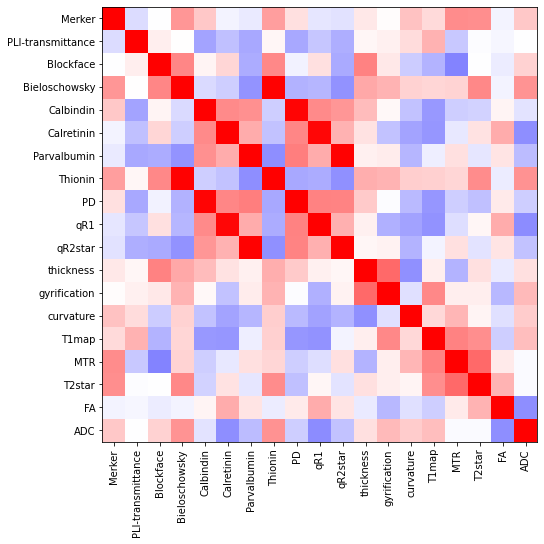

In [55]:
# correlation between features
feat_corr = np.corrcoef(struct_data.T)
allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'PD',\
               'qR1', 'qR2star', 'thickness', 'gyrification', 'curvature', 'T1map', 'MTR', 'T2star', 'FA', 'ADC']

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


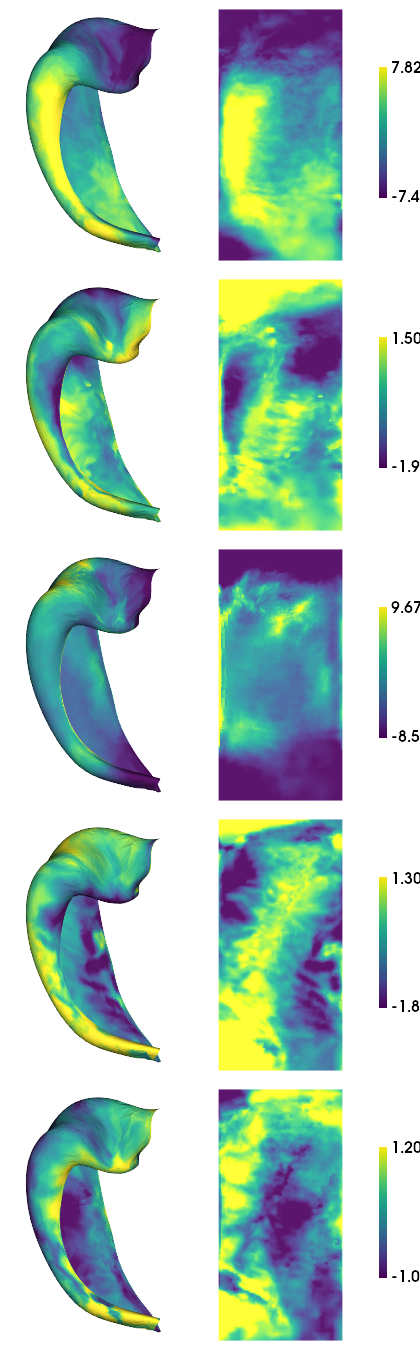

In [58]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data[:,:], sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

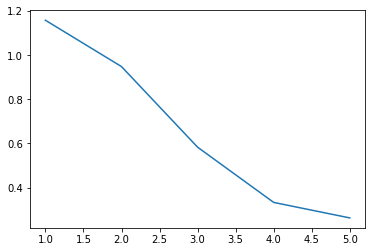

In [57]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)

In [19]:
mmgm.gradients_.shape

(7262, 5)